In [1]:
#LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import sklearn.metrics as metrics
from sklearn.metrics import r2_score,roc_auc_score,classification_report,accuracy_score,confusion_matrix,f1_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
le=LabelEncoder()
import warnings
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.stats import norm, skew
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
import sklearn.ensemble as ensemble
import sklearn.metrics as metrics
from lightgbm import LGBMClassifier
import xgboost
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn import ensemble, preprocessing, tree, model_selection, feature_selection, pipeline, metrics, svm
from imblearn import under_sampling, over_sampling, combine
from imblearn import pipeline as imb_pipeline
from imblearn import ensemble as imb_ensemble

Using TensorFlow backend.


In [2]:
#READING
train=pd.read_csv('D:/R/Jantahack Customer/train.csv')
test=pd.read_csv('D:/R/Jantahack Customer/test.csv')
print(train.shape,test.shape)

(8068, 11) (2627, 10)


In [3]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


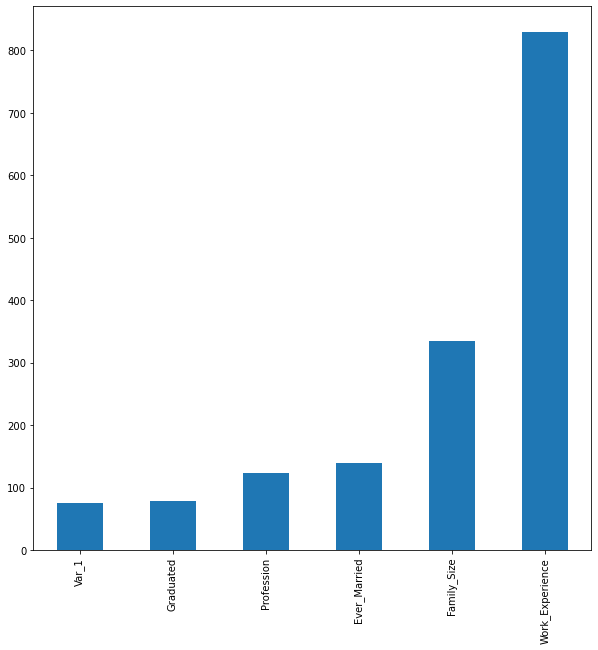

In [4]:
fig = plt.figure(figsize=(10,10))
missing = train.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [5]:
### VALUE COUNTS MULTIPLE COLUMN##
for i in train.columns:
    x=train[i].value_counts()
    print("Column name is:",i,"and it value is:",x)

Column name is: ID and it value is: 460799    1
466217    1
460042    1
462091    1
464144    1
         ..
463511    1
467609    1
461468    1
459421    1
460801    1
Name: ID, Length: 8068, dtype: int64
Column name is: Gender and it value is: Male      4417
Female    3651
Name: Gender, dtype: int64
Column name is: Ever_Married and it value is: Yes    4643
No     3285
Name: Ever_Married, dtype: int64
Column name is: Age and it value is: 35    250
37    234
33    232
42    232
27    229
     ... 
78     29
87     28
76     27
80     24
85     22
Name: Age, Length: 67, dtype: int64
Column name is: Graduated and it value is: Yes    4968
No     3022
Name: Graduated, dtype: int64
Column name is: Profession and it value is: Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: Profession, dtype: int64
Column name is: Work_Experience and it val

# MISSING VALUE TREATMENT#

In [6]:
#1.Work_Experience,Family_Size

def impute_nan(train,variable,median):
    train[variable+"_median"]=train[variable].fillna(median)
    train[variable+"_random"]=train[variable]
    ##It will have the random sample to fill the na
    random_sample=train[variable].dropna().sample(train[variable].isnull().sum(),random_state=0)
    ##pandas need to have same index in order to merge the dataset
    random_sample.index=train[train[variable].isnull()].index
    train.loc[train[variable].isnull(),variable+'_random']=random_sample


def impute_nans(test,variable,median):
    test[variable+"_median"]=test[variable].fillna(median)
    test[variable+"_random"]=test[variable]
    ##It will have the random sample to fill the na
    random_sample=test[variable].dropna().sample(test[variable].isnull().sum(),random_state=0)
    ##pandas need to have same index in order to merge the dataset
    random_sample.index=test[test[variable].isnull()].index
    test.loc[test[variable].isnull(),variable+'_random']=random_sample    
    
#OUTLIER HANDLER
def out_quant(x):
    d=np.arange(0,1,0.01)
    ds=x.quantile(d)
    return ds    

#TRain    
median=train.Work_Experience.median()
impute_nan(train,"Work_Experience",median)

#Test
medians=test.Work_Experience.median()
impute_nans(test,"Work_Experience",medians)


#TRAIN 
median=train.Family_Size.median()
impute_nan(train,"Family_Size",median)

#Test
median=test.Family_Size.median()
impute_nans(test,"Family_Size",median)

#2.Ever Married,Profession,Var_1
ts={'Graduated','Ever_Married','Var_1','Profession'}
for i in ts:
    train[i].fillna(train[i].mode()[0],inplace=True)
for col in ts:
    test[col].fillna(test[col].mode()[0],inplace=True)    

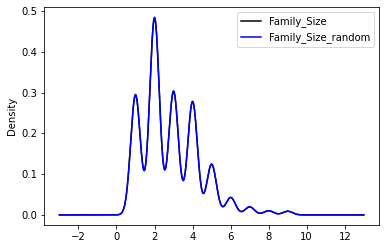

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
train['Family_Size'].plot(kind='kde', ax=ax,color='black')
train.Family_Size_random.plot(kind='kde', ax=ax, color='blue')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

train['Family_Size']=train['Family_Size_random']
test['Family_Size']=test['Family_Size_random']
train['Work_Experience']=train['Work_Experience_random']
test['Work_Experience']=test['Work_Experience_random']

del train['Work_Experience_random']
del test['Work_Experience_random']
del train['Family_Size_random']
del test['Family_Size_random']
del train['Work_Experience_median']
del test['Work_Experience_median']
del train['Family_Size_median']
del test['Family_Size_median']

In [8]:
#BINDING#
master=pd.concat([train,test],ignore_index=True)
master.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,8.0,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,9.0,High,6.0,Cat_6,A


In [9]:
## SEPEARTION CATEGORY VS NUMERIC

continuous = []
cat = []

for i in master.columns:
    if master[i].dtype == "object":
        cat.append(i)
    else: continuous.append(i)

print("Continuous:", continuous)
print("-")
print("Categorical:", cat)

Continuous: ['ID', 'Age', 'Work_Experience', 'Family_Size']
-
Categorical: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']


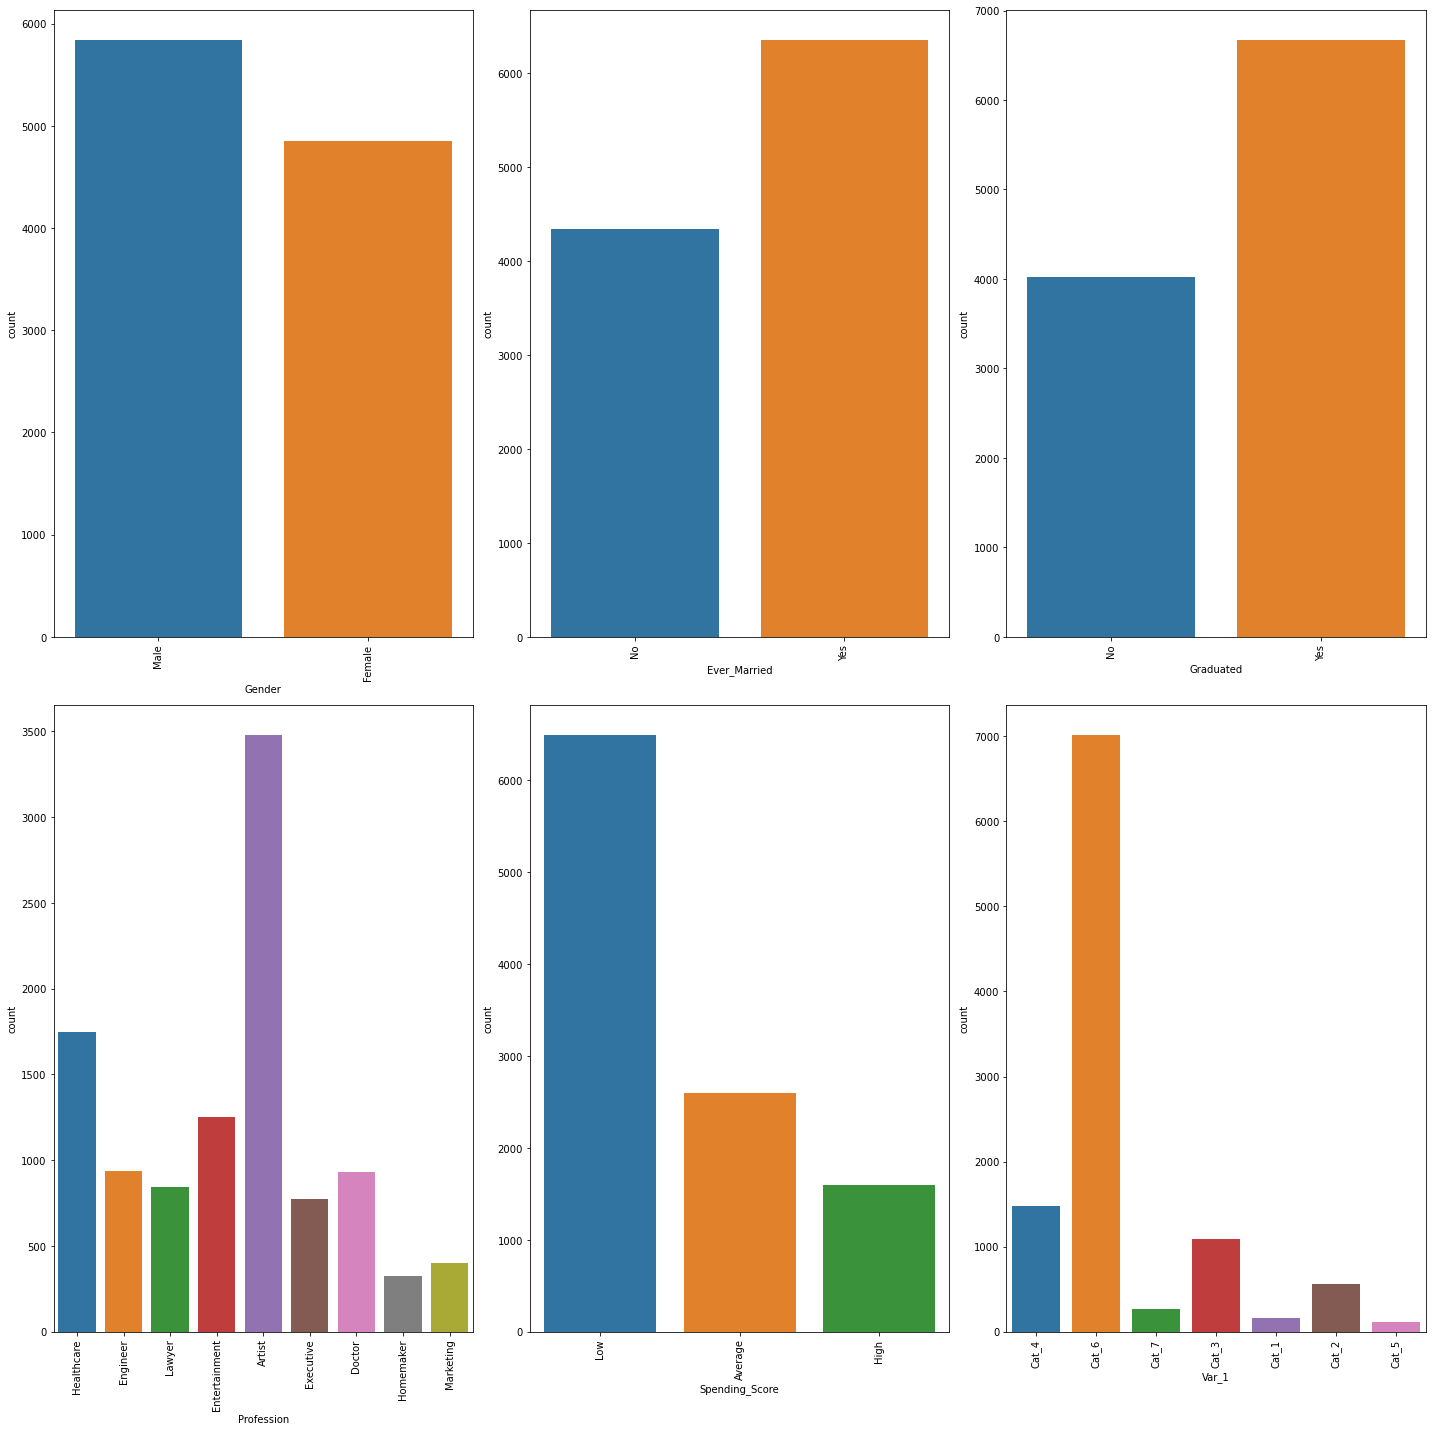

In [10]:
fig, ax=plt.subplots(2,3,figsize=(20,20))
for variable,subplot in zip(cat,ax.flatten()):
    sns.countplot(master[variable],ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
               
plt.tight_layout()
plt.show()

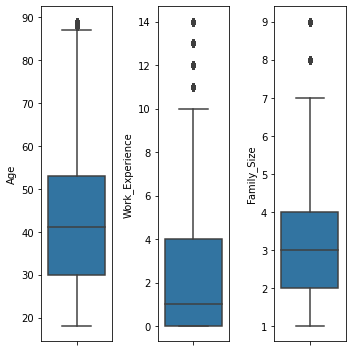

In [11]:
numerical_features = master.select_dtypes(exclude=['object']).drop(['ID'], axis=1).copy()
fig = plt.figure(figsize=(5,5))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(1,3,i+1)
    sns.boxplot(y=numerical_features.iloc[:,i])

plt.tight_layout()
plt.show()

In [12]:
cat_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
label_enc = {}
for col in cat_cols:
    master[col] = master[col].astype(str)
    enc = le.fit(master[col])
    master[col] = enc.transform(master[col])
    label_enc[col] = enc

# FEATURE ENGINEERING#

In [13]:
master['Start_at']=master['Age'] - master['Work_Experience']
master['week']=master['ID']%7
master['month']=master['ID']%30
master['year']=master['ID']%365
master['Num_weeks']=master['ID']//7
master['Num_year']=master['ID']//365
master['Quarter']=master['ID']%90
master['Num_Days']=master['ID'].values - 458982
master['NUm_weeks_2']=(master['ID'].values - 458982)//7
master['Num_Months_2']=(master['ID'].values - 458982)//30
master["Lonely"] = [1 if members<2 and age >= 60 and gender == 1 else 0 for members, age, gender in zip(master["Family_Size"].values,
                                                                                                        master["Age"].values, master["Gender"].values)]
master["Age_group"] = [1 if i<=33 else 2 if i>33 and i<65 else 3 if i>=65 and i<74 else 4 for i in master["Age"].values]

# Correlation Matrix #


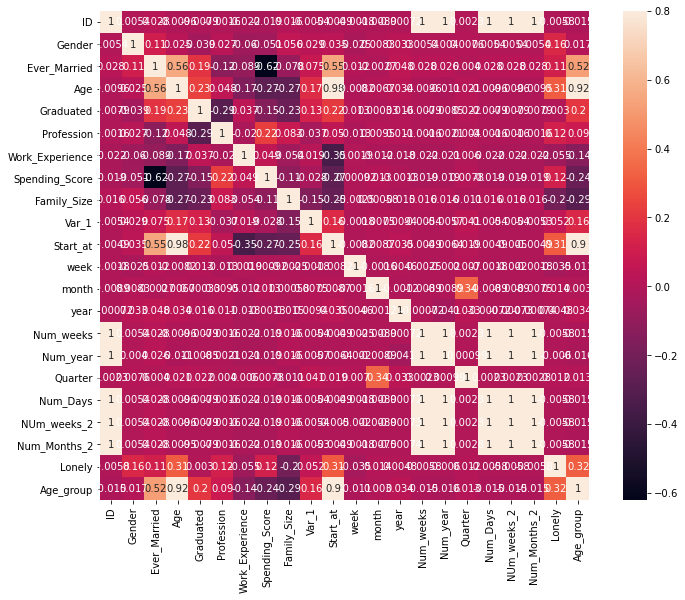

In [14]:
##CORRELATION MATRIX#
corrmat = master.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8,annot = True,square=True);

In [15]:
###########MODEL BUILDING###########
cats = ['Gender', 'Ever_Married','Graduated','Profession','Spending_Score',
'Var_1']
target_map = {'A':0, 'B':1, 'C':2,'D':3}
target_map_inverse = {0:'A', 1:'B', 2:'C',3:'D'}
master= pd.get_dummies(master, columns=cats)
X = master[master['Segmentation'].isnull()!=True].drop(['ID','Segmentation'], axis=1)
y = master[master['Segmentation'].isnull()!=True]['Segmentation'].map(target_map)
X_test = master[master['Segmentation'].isnull()==True].drop(['ID','Segmentation'], axis=1)

########SPLITTING#####
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

#SCALING
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_val=scaler.fit_transform(x_val)


In [54]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [56]:
from sklearn import base, ensemble, decomposition, metrics, pipeline, datasets, impute
from skopt import gp_minimize, space, gbrt_minimize, dummy_minimize, forest_minimize
from functools import partial
def optimize_sk(params, param_names, X, y, scoring, estimator, cv = model_selection.StratifiedKFold(n_splits = 5)):
    '''params: list of param values
    param_names: param names
    x: training exogs
    y: training endogs
    return: negative metric after k fold validation'''

    params = dict(zip(param_names, params))

    # Initialize the model
    model = estimator(**params)

    kf = cv

    scores = []
    for train_index, test_index in kf.split(X, y):
        # Split Data
        X_train, y_train = np.array(X)[train_index, :], y[train_index]
        X_test, y_test = np.array(X)[test_index, :], y[test_index]

        # Fit model
        im = impute.KNNImputer().fit(X_train)
        X_train = im.transform(X_train)
        model.fit(X_train, y_train)
        # Evaluate model
        preds = model.predict(im.transform(X_test))
        scores.append(scoring(y_test, preds))

    return -np.mean(scores)

# Scoring
def f1_score(y_true, y_pred):
    return metrics.f1_score(y_true, y_pred, average = 'macro')

def accuracy(y_true, y_pred):
    return metrics.accuracy_score(y_true, y_pred)

# Parameter Space
param_space = [
    space.Integer(100, 1000, name = 'n_estimators'),
    space.Integer(2, 25, name = 'max_depth'),
    space.Real(0, 1, name = 'max_features'),
    space.Integer(2, 25, name = 'min_samples_leaf'),
    space.Categorical(['gini', 'entropy'], name = 'criterion'),
    space.Categorical([None, 'balanced', 'balanced_subsample'], name = 'class_weight'),
    space.Categorical([True, False], name = 'bootstrap')
]
# Param names
names = ['n_estimators', 'max_depth', 'max_features', 'min_samples_leaf', 'criterion', 'class_weight', 'bootstrap']

cat_cols =  ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'ID']
cat_cols =  ['Var_1']

# Define objective - reformat it in terms of what is required for skopt
objective_optimization = partial(optimize_sk, param_names = names, X = X, y = y, 
                                scoring = accuracy, estimator = partial(ensemble.RandomForestClassifier, n_jobs = -1, random_state = 0))

# Perform Optimization
#gbrt_minimize, dummy_minimize, forest_minimize
'''skopt_optimization = gp_minimize(func = objective_optimization, 
                                dimensions = param_space, n_calls = 10, n_random_starts = 10, 
                                x0 = None, y0 = None, random_state = 10, 
                                verbose = 10)'''
skopt_optimization = dummy_minimize(func = objective_optimization, 
                                dimensions = param_space, n_calls = 10,
                                x0 = None, y0 = None, random_state = 10, 
                                verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.3812
Function value obtained: -0.5245
Current minimum: -0.5245
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 37.4608
Function value obtained: -0.5338
Current minimum: -0.5338
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 22.8180
Function value obtained: -0.5198
Current minimum: -0.5338
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 65.0151
Function value obtained: -0.5274
Current minimum: -0.5338
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.4181
Function value obtained: -0.5363
Current minimum: -0.5363
Iteration No: 6 star

In [57]:
model = pipeline.make_pipeline(impute.KNNImputer(), 
                               ensemble.RandomForestClassifier(**dict(zip(names, skopt_optimization.x)), 
                                                               n_jobs = -1, random_state = 0)).fit(X, y)

In [59]:
model_cb = CatBoostClassifier( verbose = False)

model_lgb = lgb.LGBMClassifier(n_estimators = 1000, min_samples_in_leaf = 10, learning_rate = .02, 
                          feature_fraction = .8, max_depth = 8)

# Soft Voting Classifier
model_voting = ensemble.VotingClassifier([('catboost', model_cb), ('lightgbm', model_lgb)], 
                                         voting = 'soft').fit(X, y)


In [61]:
model4 = pipeline.make_pipeline(impute.KNNImputer(n_neighbors = 10), ensemble.RandomForestClassifier(class_weight = 'balanced_subsample',
                    n_estimators = 200, max_depth = 20, criterion = 'entropy', max_features = .8, oob_score = True, random_state = 0)).fit(X, y)
model2 = lgb.LGBMClassifier(n_estimators=300, max_features = .85, max_depth = 15, learning_rate = 1.1).fit(X, y)



In [62]:

predictions_test =  pd.Series(model2.predict(X_test))
submission = pd.read_csv("D:/R/Jantahack Customer/sample_submission.csv")
submission["Segmentation"] = predictions_test
submission["Segmentation"] = submission["Segmentation"].map(target_map_inverse)
submission.to_csv("Seg.csv", index=False)

In [16]:
import lightgbm as lgb
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.5,
    'boost': 'gbdt',
    'feature_fraction': 0.7,
    'learning_rate': 0.005,
    'num_class':4,
    'metric':'multi_logloss',
    'max_depth': 8,  
    'num_leaves': 70,
    'min_data_in_leaf':40,
    'objective': 'multiclass',
    'scale_pos_weight':1,
    'verbosity': 1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1048)
predictions = np.zeros((len(X_test), 4))
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X,y)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    predictions_val = np.argmax(clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration), axis=1)
    
    print("CV score: {:<8.5f}".format(accuracy_score(predictions_val, y.iloc[val_idx])))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

Fold 0
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_logloss: 0.853107	valid_1's multi_logloss: 1.04613
[2000]	training's multi_logloss: 0.706928	valid_1's multi_logloss: 1.04251
Early stopping, best iteration is:
[1392]	training's multi_logloss: 0.787878	valid_1's multi_logloss: 1.04025
CV score: 0.53284 
Fold 1
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_logloss: 0.851537	valid_1's multi_logloss: 1.05979
[2000]	training's multi_logloss: 0.708511	valid_1's multi_logloss: 1.05394
Early stopping, best iteration is:
[1825]	training's multi_logloss: 0.73002	valid_1's multi_logloss: 1.05301
CV score: 0.51549 
Fold 2
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_logloss: 0.858985	valid_1's multi_logloss: 1.04118
[2000]	training's multi_logloss: 0.71606	valid_1's multi_logloss: 1.03084
[3000]	training's multi_logloss: 0.612155	valid_1's multi_logloss: 1.03651
Early sto

In [17]:
predictions_test = np.argmax(predictions, axis=1)
submission = pd.read_csv("D:/R/Jantahack Customer/sample_submission.csv")
submission["Segmentation"] = predictions_test
submission["Segmentation"] = submission["Segmentation"].map(target_map_inverse)
submission.to_csv("janatahack_mobi.csv", index=False)